### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Fall 2018 ###

# Updato (UAV Package Delivery And Trajectory Optimization) #

#### Huanran Li (hli488@wisc.edu; 9075285727)
#### Chongxi Yuan (cyuan42@wisc.edu; 9075957069)
#### Jingqi Duan (jduan27@wisc.edu; 9075308198)


### Table of Contents

1. [Introduction](#1.-Introduction)  
    1. [Overview](#1a.-Overview)  
    2. [History and Potential](#1b.-History-and-Potential)  
    3. [Data Generation and Assumptions](#1c.-Data-Generation-and-Assumptions)  
1. [Mathematical Model](#2.-Mathematical-model)
    1. [Constants](#2a.-Constants)
    2. [Models & Variables](#2b.-Models-&-Variables)  
        2B-1.[Base Model](#2b-1.-Base-Model)  
        2B-2.[Energy Saver Model](#2b-2.-Energy-Saver-Model)  
        2B-3.[Time Saver Model](#2b-3.-Time-Saver-Model)  
        2B-4.[Terrain Adaption Model](#2b-4.-Terrain-Adaption-Model)  
1. [Solution](#3.-Solution)  
    1. [Base Model](#3a.-Base-Model)
    1. [Energy Saver Model](#3b.-Energy-Saver)
    1. [Time Saver Model](#3c.-Time-Saver)
    1. [Terrain Adaption Model](#3d.-Terrain-Adaption)
1. [Results and Discussion](#4.-Results-and-Discussion)
    1. [Route Results Comparison](#4a.-Route-Results-Comparison)
    1. [Energy Consumption](#4b.-Energy-Consumption)
    1. [Time length Results](#4c.-Time-length-Results)
    1. [Adjusted Z Axis Position](#4d.-Adjusted-Z-Axis-Position)
    1. [Calculation Time](#4e.-Calculation-Time)
    1. [Effect difference between L-inf Regularization and Max Cap](#4f.-Effect-difference-between-L-inf-Regularization-and-Max-Cap)
    1. [Effect of Wind Resistance and Dropping Speed Limit](#4e.-Effect-of-Wind-Resistance-and-Dropping-Speed-Limit)
1. [Conclusion](#5.-Conclusion)
    1. [Summary](#5.a-Summary)
    1. [Future Directions](#5.b-Future-Directions)
1. [Code Appendix](#6.-Code-Appendix)

## 1. Introduction ##

### 1a. Overview###
In this project we will find a way to optimize the route for UAV (unmanned aerial vehicle) package delivery. A typical setting for the problem is to have a drone fly through several delivery destinations, drop the corresponding package, and return back after all packages are dropped. In addition to generating the optimal path, we also investigated the effect of several factors on the path, including wind resistance, feasible dropping range, dropping speed limit (corner speed) and maximum throttle limit. 


There are 2 objectives in the optimization of the package delivery routes.   
* The **first** objective requires a drone to get back within a specific time while **minimizes energy cost** (the electricity consumed by motors).  
* The **second** objective sets the maximum of energy that a drone can spend to **minimize the time cost** (the time needed to finish the task). 

### 1b. History and Potential### 

Recently, the potential of UAV has been recognized in a variety of ways, such as entertainment, photographing, and even military purposes. Meanwhile, a fast and efficient logistics system is needed more than ever due to the increase of demand for online retail. In the nearest future, it is greatly possible to use drones in package delivery if they are able to carry many cargos stably. 

Amazon has started to explore the possibilities of UAV package delivery since 2016 and released several videos of  “[prime air](https://www.amazon.com/Amazon-Prime-Air/b?ie=UTF8&node=8037720011)”. 
Amazon believes that by using UAVs, packages could be delivered to their customers within 30 minutes.

It is believed that drones will enhance the current logistics system by increasing its speed and energy efficiency. Compared to the current delivery system of trucks, an important advantage for drones is that they can fly on customized routes instead of built roads. In this project, we will explore how to improve the time and energy efficiency by optimizing the route of UAV during delivery. We will first focus on 2D routes and then consider the same problem in 3D space.

### 1c. Data Generation and Assumptions### 
Most of the constant used in the model are approximated based on reality, such as the mass of the drone and the velocity it could achieve. The scale of the map is also based on the size of a small town (5km^2).

In the map, delivery destination points are designed with 2 criteria:
* Better show the effect of different factors
* Reasonable scale in reality

The same map and destinations will be used in several different models to show comparison between their results.

And there are several assumptions we made to simplify the problem:
* A drone can carry and deliver several packages in a single run. 
* The drone starts from the origin on the map and returns to the origin after all packages are delivered
* Since the mass of packages is probably much smaller than that of the drone, the package mass will not be taken into account in this project.
* Wind speed is constant and independent of time and position.
* Throttle is modelled with 3 components in x, y and z direction.



## 2. Mathematical model ##

There will be two major model in this project. They have different purpose on optimizing the route and the throttle. The first model is "Energy Saver", which is based on the given dropping feasible region and the maximum time to generate a route that saves the most energy. The second mode is "Time saver", which needs maximum trottle and battery to find the route that would take the least time. These models contains LP and MIP constraint and objectives, and they are built on Feedback Control System and Traveler Salesman.

### 2a. Constants ###
We have a set of constant for making this problems value closer to the reality. Here is the Constants.

| Names        | Unit|Meaning          |
| ------------- |:-------------:| --------:|
|N| Dimensions|Dimension index|
|M| |number of target locations|
|P| |number of packages on the air|
|I| Minute|The largest time index|
|G[1:N; 1:M]|Meter| The M number of locations of the target delivery area in x,y,z axis|
|W[1:N]| Meter/Minute|Wind flow in x, y, z direction|
|Mv| Kilogram|Mass of the vehicle|
|Ag[0;0;g]| Meter/Minute^2|gravity acceleration| 
|T[1:M]| Minute|Time for hitting target(only used in the first Model)|
|MAX_Range| Meter|A very large number which confines the flying area|
|range_limit| Meter|A side length of the feasible dropping square|
|coeff_v| |coeff_v * current velocity = wind resistance|
|vlimit| Meter\Minute|The maximum speed that UAV could reach while dropping the packages|
|tr_limit| 1/3600 Newton|The maximum throttle UAV could provide|
|battery| 1/3600 Newton * Minute|The maximum energy UAV could spend in a single trip|
|lambda||trade off coefficient for L-inf regularization of throttle|



### 2b. Models & Variables ###

#### 2b-1. Base Model #### 


The base model we have is derived from the Hovercraft Example. What is added is the relation between the real throttle and the acceleration variable, while taking the wind speed and mass of the drone in consideration. Besides, the resistance caused by wind when the drone is flying would also be taken into consideration. Like the provided example of hovercraft, we have to tell the drone the exact time when it need to drop a specific package. The advantage of this model is simple: the model is calculated super fast.


##### Variables#####
| Names        | Meaning          |
| ------------- |:-------------|
|x\[1:N;1:I\]| Displacement of the UAV in x,y,z axis at time I.|
|v\[1:N;1:I\]| Velocity of the UAV in x,y,z axis at time I.|
|a\[1:N;1:I\]| Acceleration of the UAV in x,y,z axis at time I.|
|tr\[1:N,1:I\]| Thrust of the UAV’s motors in x,y,z directions at time I|
|resistance\[1:N, 1:I\]| air resistance modelled proportional to speed|

##### Model#####

$$\begin{aligned}
  {\text{minimize}}\qquad& \sum{tr^2} \\
    \text{subject to:}\qquad
    & \text{Position velocity relation:} \\
    & \qquad x_{t+1} = x_t+v_t \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Velocity acceleration relation:}\\
    & \qquad v_{t+1} = v_{t}+a_{t} \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Relation between thrust and acceleration:}\\
    & \qquad tr_{t} +W - resistance = Mv*(a_{t}+Ag) \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Set the resistance to be linearly related to the moving speed}\\
    & \qquad resistance_t = coeff_v * \sum{v_t} \\
    & \text{Set starting position and velocity to 0:}\\
    & \qquad x_{1} = v_{1} =0 \\
    & \text{Set final position and velocity to 0:}\\
    & \qquad x_{I} = v_{I} =0 \\
    & \text{Make drone past delivery destination at given time t:}\\
    & \qquad x_{i_{t}} = G_{i} \qquad for\, i= 1 \, to \, M 
    \end{aligned}$$

#### 2b-2. Energy Saver Model #### 

Instead of setting the time of dropping packages, we let this model to find the not only the path, but also the order and the time of dropping several packages by itself. By implementing a similar algorithm as the Traveler Salesman Problem, we only need to set the coordinates of the dropping area, and let the model to find the best path to save energy. The energy saving advantages of this model would be further shown in Discussion. However, this will take longer time to solve than the base model.   

Compared to the base model, several new factors are also introduced into this Energy Saver Model.

| Factor        | Functionality          |
| ------------- |:-------------|
|Dropping Range| Makes an area instead of a point acceptable for package dropping|
|Throttle Maximum| Creates a maximum cap for throttle output variable|
|Corner Speed| Creates a maximum cap for travelling speed when the package is dropped|

##### Variables#####
| Names        | Meaning          |
| ------------- |:-------------|
|x\[1:N;1:I\]| Displacement of the UAV in x,y,z axis at time I.|
|v\[1:N;1:I\]| Velocity of the UAV in x,y,z axis at time I.|
|a\[1:N;1:I\]| Acceleration of the UAV in x,y,z axis at time I.|
|tr\[1:N,1:I\]| Thrust of the UAV’s motors in x,y,z directions at time I|
|pkg\[1:M, 1:I\]| **Binary** variable: <br>0 represent UAV reaches a specific dropping location(locations total is M) at time I;<br>otherwise 1|
|resistance\[1:N, 1:I\]| air resistance modelled proportional to speed|
|max\_tr\[1:N\]| The maximum trottle that the drone used|

##### Model#####

$$\begin{aligned}
  {\text{minimize}}\qquad& \sum{tr^2} + lambda * \sum{max\_tr} \\
    \text{subject to:}\qquad
    & \text{Position velocity relation:} \\
    & \qquad x_{t+1} = x_t+v_t \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Velocity acceleration relation:}\\
    & \qquad v_{t+1} = v_{t}+a_{t} \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Relation between thrust and acceleration with resistance:}\\
    & \qquad tr_{t} +W - resistance_t = Mv*(a_{t}+Ag) \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Set starting position and velocity to 0:}\\
    & \qquad x_{1} = v_{1} =0 \\
    & \text{Set final position and velocity to 0:}\\
    & \qquad x_{I} = v_{I} =0 \\
    & \text{Set the resistance to be linearly related to the moving speed}\\
    & \qquad resistance_t = coeff_v * \sum{v_t} \\
    & \text{Set the trottle maximum}\\
    & \qquad |tr_t| \le \text{tr_limit}\\
    & \text{Make pkg to be 0 when drone are passing dropping feasible area}\\
    & \qquad |x_t - G_i| \le pkg_{t,i} * \text{MAX_Range} + \text{range_limit} \quad for \, i = 1 \dots P\\
    & \text{Make drone's velocity not exceed vlimit while dropping packages (we are only using MAX_Range as a large number here)}\\
    & \qquad ||v_t|| \le pkg_{t,i} * \text{MAX_Range} + vlimit \quad for \, i = 1 \dots P\\
    & \text{Demand only one 0 exists for each package, which means the drone would drop the package and only once.}\\
    & \qquad \sum{pkg_i} = I-2 \quad for \, i = 1 \dots P\\
    & \text{Find the max throttle}\\
    & \qquad \text{max_tr} \ge tr_t \quad for \, t = 1 \dots I\\
    \end{aligned}$$

#### 2b-3. Time Saver Model #### 

The Time Saver Model is improved from the the Energy Saver Model. Instead of minimizing the energy cost, a limited amount of battery energy is given, and the Time Saver Model will minimize the time used to complete all delivery missions. To achieve this, we introduced a new binary vector "pos", which would be forced to 0 when the drone is not at the origin. By maximizing the sum of the pos, the route would take the drone back to origin using as short time as possible. The advantage of this model is that the path would not be limited by the max amount of time we give, and it would be more practical in reality since time is a more important factor than electricity in logistics. The calculation cost of this model is also greater: the time it spends would be much more than the previous models.  


##### Variables#####
| Names        | Meaning          |
| ------------- |:-------------|
|x\[1:N;1:I\]| Displacement of the UAV in x,y,z axis at time I.|
|v\[1:N;1:I\]| Velocity of the UAV in x,y,z axis at time I.|
|a\[1:N;1:I\]| Acceleration of the UAV in x,y,z axis at time I.|
|tr\[1:N,1:I\]| Thrust of the UAV’s motors in x,y,z directions at time I|
|pkg\[1:M, 1:I\]| **Binary** variable: <br>0 represents UAV reaches a specific dropping location(locations total is M) at time I;<br>otherwise 1|
|resistance\[1:N, 1:I\]| air resistance modelled proportional to speed|
|pos\[1:I-1\]| **Binary** variable: <br>0 represents drone is not back to origin at time t+1<br>otherwise 1|

##### Model#####

$$\begin{aligned}
  {\text{maximize}}\qquad&  \sum{pos}\\
    \text{subject to:}\qquad
    & \text{Position velocity relation:} \\
    & \qquad x_{t+1} = x_t+v_t \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Velocity acceleration relation:}\\
    & \qquad v_{t+1} = v_{t}+a_{t} \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Relation between thrust and acceleration with resistance:}\\
    & \qquad tr_{t} +W - resistance_t = Mv*(a_{t}+Ag) \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Set starting position and velocity to 0:}\\
    & \qquad x_{1} = v_{1} =0 \\
    & \text{Set final position and velocity to 0:}\\
    & \qquad x_{I} = v_{I} =0 \\
    & \text{Set the resistance to be linearly related to the moving speed}\\
    & \qquad resistance_t = coeff_v * \sum{v_t} \\
    & \text{Set the trottle maximum}\\
    & \qquad |tr_t| \le \text{tr_limit}\\
    & \text{Make pkg to be 0 when drone are passing dropping feasible area}\\
    & \qquad |x_t - G_i| \le pkg_{t,i} * \text{MAX_Range} + \text{range_limit} \quad for \, i = 1 \dots P\\
    & \text{Make drone's velocity not exceed vlimit while dropping packages (we are only using MAX_Range as a large number here)}\\
    & \qquad ||v_t|| \le pkg_{t,i} * \text{MAX_Range} + vlimit \quad for \, i = 1 \dots P\\
    & \text{Demand only one 0 exists for each package, which means the drone would drop the package and only once.}\\
    & \qquad \sum{pkg_i} = I-2 \quad for \, i = 1 \dots P\\
    & \text{Make the caps for the totol energy usage}\\
    & \qquad \sum{||tr||} \le battery \\
    & \text{Force pos_t to be 0 when drone's coordinate is not at origin} \\
    & \qquad pos_t * x_{t+1} = 0 \quad for \, t = 1 \dots I-1 \\
    & \text{Force drone not to leave origin when it is back to avoid the case when drone keeps getting back to origin}\\
    & \qquad pos_t \le pos_{t+1} \quad for \, t = 1 \dots I-2 \\
    \end{aligned}$$

#### 2b-4. Terrain Adaption Model ####

This model is an additional tool for 2b-2 and 2b-3 model. In previous 2b-2 and 2b-3, it is assumed that the drone drops the package on the ground-level where the z coordinate value is 0. In the Terrain Adaption Model, a map is defined. The packages will now be dropped on the groud of the given terrain instead of aboslute sea level(z=0). This model will further optimize the trajectory of the drone based on the additional information of the map.  

##### Special consant#####

| Names        | Meaning          |
| ------------- |:-------------|
|x_cord|A vetor used to define the x index of the terrain|
|y_cord|A vetor used to define the y index of the terrain|
|z_cord|A matrix used to define the z index for each poitn of the terrain|

##### Variable #####

| Names        | Meaning          |
| ------------- |:-------------|
|z\[1:I\]| The distance between the drone and the ground|
|v\[1:I\]| The velocity offset on z-axis|
|a\[1:I\]| The acceleration offset on z-axis|
|tr\[1:I\]| The throttle offset on z-axis|

##### Constraint #####

$$\begin{aligned}
  {\text{minimize}}\qquad&  \sum{tr^2}\\
    \text{subject to:}\qquad
    & \text{Position velocity relation:} \\
    & \qquad z_{t+1} = z_t+v_t \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Velocity acceleration relation:}\\
    & \qquad v_{t+1} = v_{t}+a_{t} \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Relation between thrust and acceleration with resistance:}\\
    & \qquad tr_{t} +W - resistance_t = Mv*(a_{t}+Ag) \quad for \, t=1,2,\dots ,T-1 \\
    & \text{Set starting height to zero}\\
    & \qquad z_1 = 0\\
    & \text{Set ending height to zero}\\
    & \qquad z_I = 0\\
    & \text{Make the offset of z_t change with the terrain change(allow_range is mostly set to be a really small number like 1)}\\
    & \qquad |z_t - z\_cord_{x_t,y_t}| <= allow\_range\\
    \end{aligned}$$

## 3. Solution ##
In this section we will demonstrate solving the problem using the 4 models discussed earlier in section 2. We will show the results of the solution for each of the 4 models, but comparison between different models and factors will be discussed in more detail in section 4 "Results and Discussions".

Because of the huge complexity of the model in 3 dimension, it would take more than 15 hours to solve  the Time Saver Model. We choose to present our solution in 2 dimensions. Only Terrain Adaption Model would be solved based on Energy Saver Model in 3 Dimensions.  

#### Helper Function####
We implemented 2 helper functions to plot the results generated by our models. They will be used in later solutions, thus they are placed in the front.

In [11]:
using JuMP, PyPlot

#This function print all need graph is model is 2D
function print2D(name)
    
    #first graph: x-y locations and optimal path
    pos = getvalue(x)
    figure(figsize=(12,4))
    plot( pos[1,:], pos[2,:], "b.-", markersize=4 )
    plot( pos[1,I], pos[2,I], "b.", markersize=12 )
    plot( G[1,:], G[2,:], "r.", markersize=12 )
    #acceptable dropping square
    for i in 1:M
        broken_barh([(G[1,i] - range_limit, 2*range_limit)],(G[2,i] - range_limit, 2*range_limit), edgecolors = "blue", facecolors = "white")
    end
    axis("equal");
    xlabel("X(meter)"); ylabel("Y(meter)"); grid();title(name)

    #second graph: Throttle vs time
    uopt = getvalue(tr[1,:])
    uopt2 = getvalue(tr[2,:])
    figure(figsize=(12,3))
    index_x = linspace(1,I-1,I-1)
    plot( index_x, uopt[1:I-1], "-", markersize=8 , label = "tr_x")
    plot( index_x, uopt2[1:I-1], "-", markersize=8 , label = "tr_y")
    xlabel("Time(min)"); ylabel("Throttle(/3600 = N)"); grid()
    legend()
    
    #third graph: Acceleration vs time
    aopt = getvalue(a[1,:])
    aopt2 = getvalue(a[2,:])
    figure(figsize=(12,3))
    plot( index_x, aopt[1:I-1], "-", markersize=8 , label = "a_x")
    plot( index_x, aopt2[1:I-1], "-", markersize=8 , label = "a_y")
    xlabel("Time(min)"); ylabel("Acceleration(meter/minute^2)"); grid()
    legend()
    
    #fourth graph: Velocity vs time
    figure(figsize = (12,3))
    index_x = linspace(1,I,I)
    vopt_x = getvalue(v[1,:])
    vopt_y = getvalue(v[2,:])
    #total velocity calculation
    vopt = (vopt_x.^2 .+ vopt_y.^2).^0.5
    plot( index_x, vopt_x[1:I], "-", markersize=8 , label = "v_x")
    plot( index_x, vopt_y[1:I], "-", markersize=8 , label = "v_y")
    plot( index_x, vopt[1:I], "-", markersize=8 , label = "v_total")
    xlabel("Time(min)"); ylabel("Velocity(meter/minute)"); grid()
    legend()
    
    #model statistics 
    println("Model Energy Used: ", fuel_m2)
    println("Calculation time: = ", getsolvetime(m2), " sec")
end


print2D (generic function with 1 method)

In [4]:
using PyPlot
function print3D(name)
    #position in 2D
    pos = getvalue(x)
    figure(figsize=(12,4))
    plot( pos[1,:], pos[2,:], "b.-", markersize=4 )
    plot( pos[1,I], pos[2,I], "b.", markersize=12 )
    plot( G[1,:], G[2,:], "r.", markersize=12 )
    axis("equal");
    xlabel("X(meter)"); ylabel("Y(meter)"); grid();title(name)

    #Z change with time
    figure(figsize = (12,3))
    index_x = linspace(1,I,I)
    z = getvalue(x[3,:])
    plot( index_x, z[1:I], "-", markersize=8 , label = "z")
    xlabel("Time(minute)"); ylabel("z(meter)"); grid()
    legend()

    #position in 3D
    figure()
    pos = getvalue(x)
    plot3D(pos[1,1:I], pos[2,1:I], pos[3,1:I], "-", markersize=8)
    xlabel("x(meter)");ylabel("y(meter)");zlabel("z(meter)")
    hold
    surf(x_cord, y_cord, z_cord, rstride=500, cstride=500,cmap="rainbow", edgecolor="black", linewidths=.5)

    #trust
    figure(figsize = (12,3))
    uopt = getvalue(tr[1,:])
    uopt2 = getvalue(tr[2,:])
    uopt3 = getvalue(tr[3,:])
    index_x = linspace(1,I-1,I-1)
    plot( index_x, uopt[1:I-1], "-", markersize=8 , label = "thrust_x")
    plot( index_x, uopt2[1:I-1], "-", markersize=8 , label = "thrust_y")
    plot( index_x, uopt3[1:I-1], "-", markersize=8 , label = "thrust_z")
    xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid()
    legend()

    #velocity
    figure(figsize = (12,3))
    index_x = linspace(1,I,I)
    vopt_x = getvalue(v[1,:])
    vopt_y = getvalue(v[2,:])
    vopt_z = getvalue(v[3,:])
    vopt = (vopt_x.^2 .+ vopt_y.^2 + vopt_z.^2).^0.5
    plot( index_x, vopt_x[1:I], "-", markersize=8 , label = "v_x")
    plot( index_x, vopt_y[1:I], "-", markersize=8 , label = "v_y")
    plot( index_x, vopt_z[1:I], "-", markersize=8 , label = "v_z")
    plot( index_x, vopt[1:I], "-", markersize=8 , label = "v_total")
    xlabel("Time(minute)"); ylabel("Velocity(meter/minute^2)"); grid()
    legend()
    
    #statistics
    println("Model Energy Used: ", fuel_m3)
    println("Calculation time: = ", getsolvetime(m3), " sec")
end


print3D (generic function with 1 method)

#### Constant Data####

Consult table in part 2a for detailed information

In [43]:
M = 5 #number of dropping area
P = 5 #number of packages
I = 50 #maximum time of flying
G = [0 1800 -4500 3600 -3000;-1000 1350 4500 -3600 -3000] #dropping target coordinates
W = [0,0] #wind speed
Mv = 5 #mass of the drone
Ag = [0,0] #gravity acceleration
T = [10, 20, 25, 35, 40, 45] #time index when the drone drop the package
MAX_Range = 10^6 #max range the drone could fly
range_limit = 0; #length of the side for the square dropping area

### 3a. Base Model###
This is the model discussed earlier in part 2b-1.

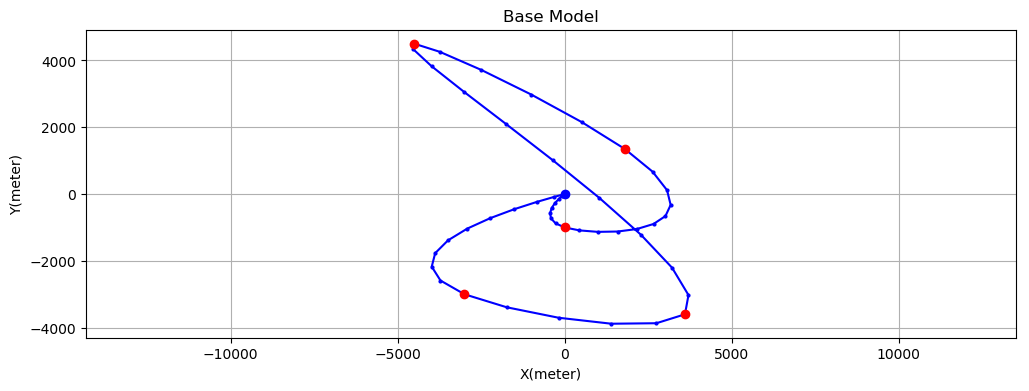

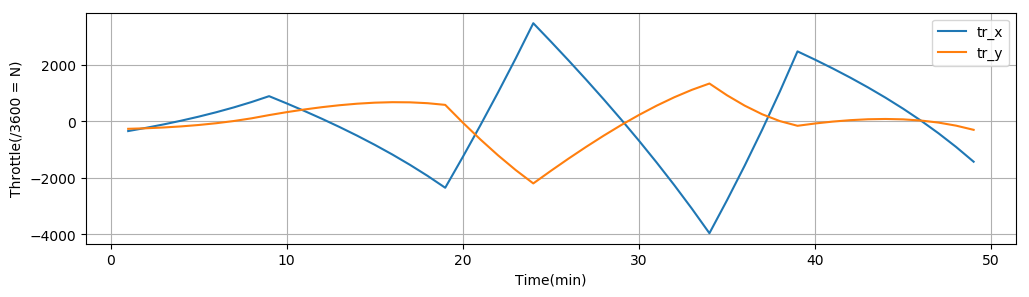

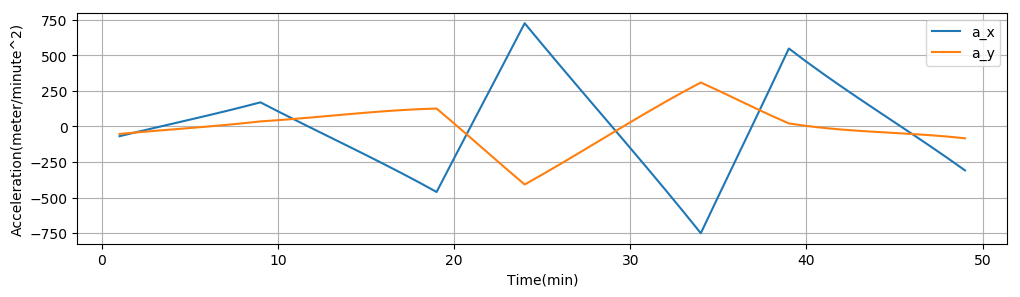

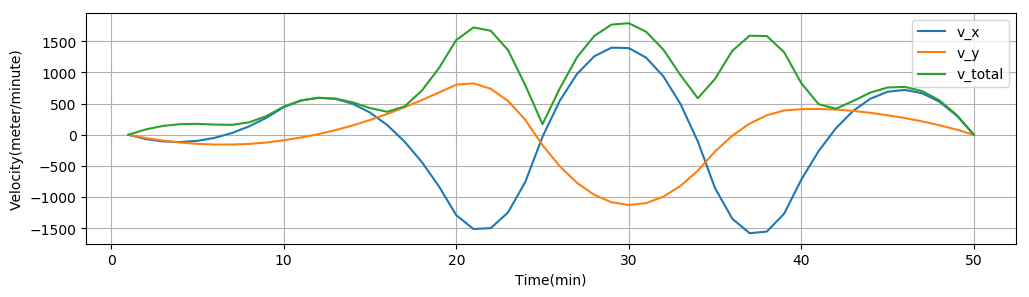

Academic license - for non-commercial use only
Optimal
Model Energy Used: 11946.090838402462
Calculation time: = 0.000995635986328125 sec


In [51]:
using JuMP, Gurobi

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, h[1:P, 1:I])
@variable(m2, resistance[1:2,1:I])

# UAV starts at origin (0,0)
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])    # velocity and acceleration
    @constraint(m2, resistance[t] == coeff_v * sum(v[:,t])) #
    @constraint(m2, tr[:,t] + W - resistance[t] .== (Mv) .* (a[:,t] + Ag))
end


for i in 1:M
    @constraint(m2, x[:, T[i]] .== G[:,i])
end

@objective(m2, Min, sum(tr.^2))

status = solve(m2)
println(status)

fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2)).^0.5
print2D("Base Model")

In [52]:
#recording the data
x1 = getvalue(x)
tr1 = getvalue(tr)
v1 = getvalue(v)
a1 = getvalue(a)
fuel_m1 = fuel_m2
time1 = getsolvetime(m2);

### 3b. Energy Saver ###

Note: Since L-inf regularization would shape the path in a very similar way as the limiting throttle maximum. So we are only going to limit the maximum of throttle, which makes more sense in reality.

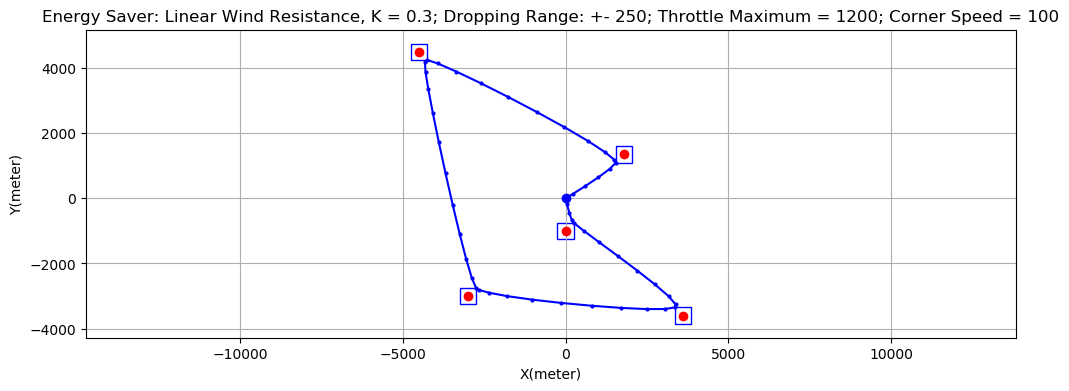

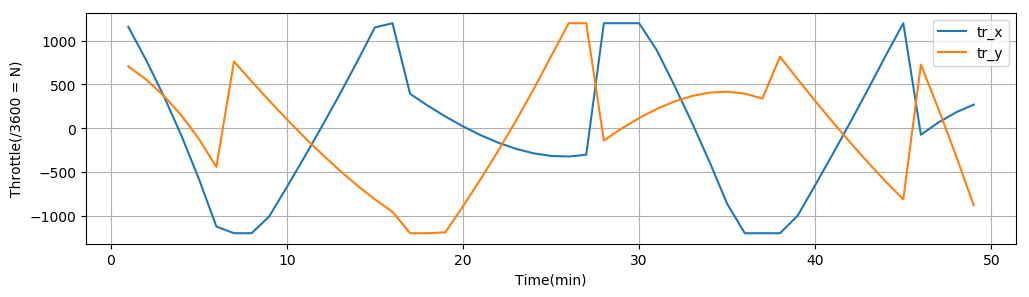

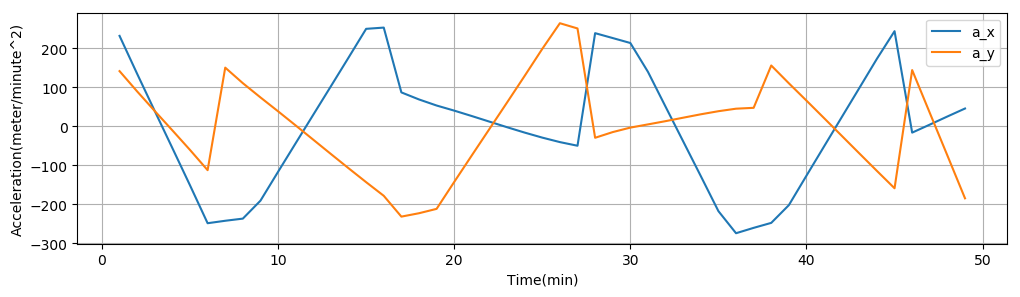

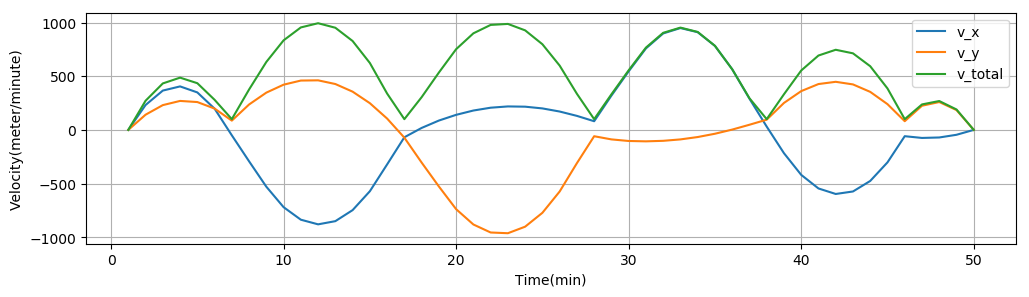

Academic license - for non-commercial use only
Optimal
Model Energy Used: 6731.258682917065
Calculation time: = 47.22983741760254 sec


In [21]:
using JuMP, Gurobi

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

coeff_v = 0.3
vlimit = 100
range_limit = 250

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I], Bin)
@variable(m2, resistance[1:2,1:I])

# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration
    @constraint(m2, resistance[t] == coeff_v * sum(v[:,t])) #
    @constraint(m2, tr[:,t] + W - resistance[t] .== (Mv) .* (a[:,t] + Ag))
    @constraint(m2, tr[:,t] .<= 1200)
    @constraint(m2, -tr[:,t] .<= 1200)
    
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range + range_limit)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range - range_limit)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range + range_limit)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range - range_limit)
        @constraint(m2, v[1,t]^2+v[2,t]^2  <= pkg[packages, t] * MAX_Range + vlimit^2)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

@objective(m2, Min, sum(tr.^2))

status = solve(m2)
println(status)
fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2))^0.5

print2D("Energy Saver: Linear Wind Resistance, K = 0.3; Dropping Range: +- 250; Throttle Maximum = 1200; Corner Speed = 100")

In [22]:
#recording the data
x2 = getvalue(x)
tr2 = getvalue(tr)
v2 = getvalue(v)
a2 = getvalue(a)
fuel_m22 = fuel_m2
time2 = getsolvetime(m2);

### 3c. Time Saver ###


Academic license - for non-commercial use only
Optimal


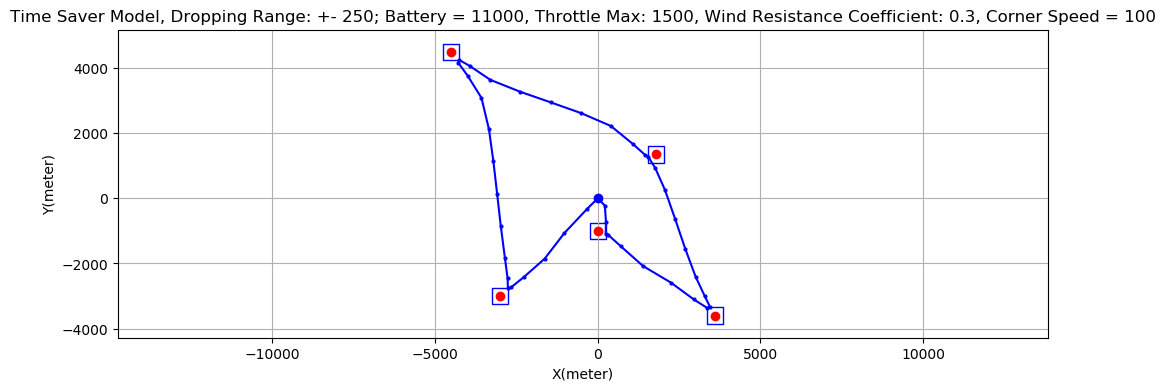

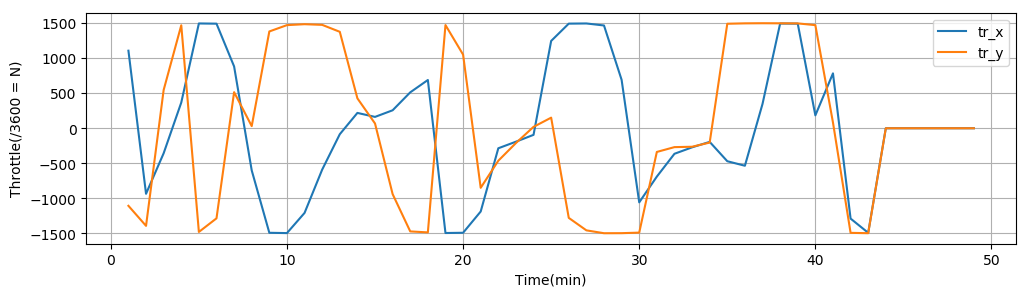

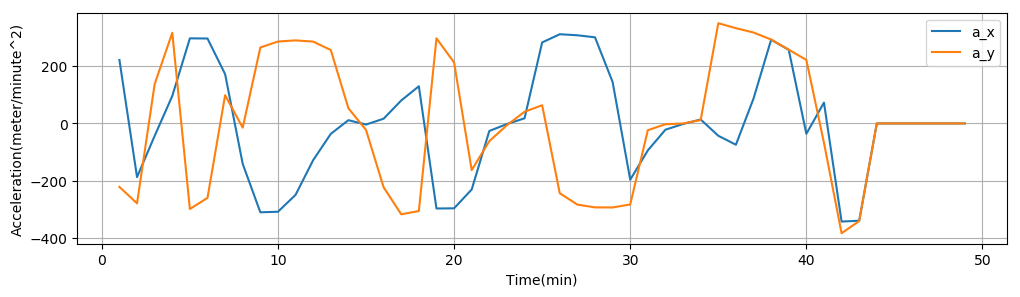

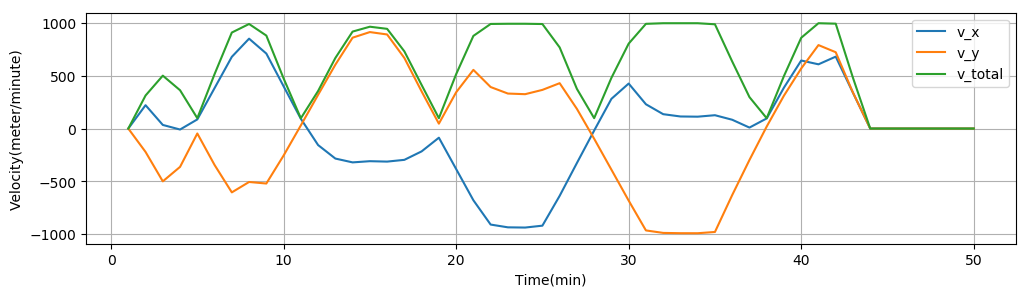

Model Energy Used: 9977.960023002888
Calculation time: = 14264.12688446045 sec


In [122]:
using JuMP, Gurobi, Mosek

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

coeff_v = 0.3
vlimit = 100
tr_limit = 1500
battery = 10000
range_limit = 250

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I-1], Bin)
@variable(m2, resistance[1:2,1:I])
@variable(m2, pos[1:I-1], Bin)

# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])
@constraint(m2, resistance[:,1] .== [0,0])
@constraint(m2, sum(tr[1,:].^2 + tr[2,:].^2) <= battery^2)

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration
    @constraint(m2, resistance[t] == coeff_v * sum(v[:,t]))
    @constraint(m2, tr[:,t] + W - resistance[t] .== (Mv) .* (a[:,t] + Ag))
    @constraint(m2, tr[:,t] .<= [tr_limit,tr_limit])
    @constraint(m2, -tr[:,t] .<= [tr_limit,tr_limit])
    @constraint(m2, pos[t] * x[1,t+1] == 0)
    @constraint(m2, pos[t] * x[2,t+1] == 0)
    
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range + range_limit)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range - range_limit)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range + range_limit)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range - range_limit)
        @constraint(m2, v[1,t]^2+v[2,t]^2  <= pkg[packages, t] * MAX_Range + vlimit^2)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

for t in 1:I-2
    @constraint(m2, pos[t] <= pos[t+1])
end

@objective(m2, Max, sum(pos))

status = solve(m2)
println(status)

fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2)).^0.5
print2D("Time Saver Model, Dropping Range: +- 250; Battery = 11000, Throttle Max: 1500, Wind Resistance Coefficient: 0.3, Corner Speed = 100")

In [123]:
#recording the data
x3 = getvalue(x)
tr3 = getvalue(tr)
v3 = getvalue(v)
a3 = getvalue(a)
fuel_m3 = fuel_m2
time3 = getsolvetime(m2);

### 3d. Terrain Adaption ###

Note: Because this model is a tool to help the optimal path to adapt with real terrain, we will run the Energy Saver Model first and with a simpler model. Then we will use the optimal path and modify it by this model.

In [55]:
#Generate a plain horizon for the 3D Energy Saver Model
x_cord = linspace(-5000,5000,10001)
y_cord = linspace(-5000,5000,10001)
z_cord = zeros(10001, 10001);

In [56]:
using JuMP, Gurobi

G = [0 1800 -4500 3600 -3000;-1000 1350 4500 -3600 -3000]
M = 5
P = 5
I = 50
W = [0,0,0]
Mv = 5
Ag = [0,0, 9.8]
MAX_Range = 10^4
height=20

20

Academic license - for non-commercial use only
Optimal
Model Energy Used: 

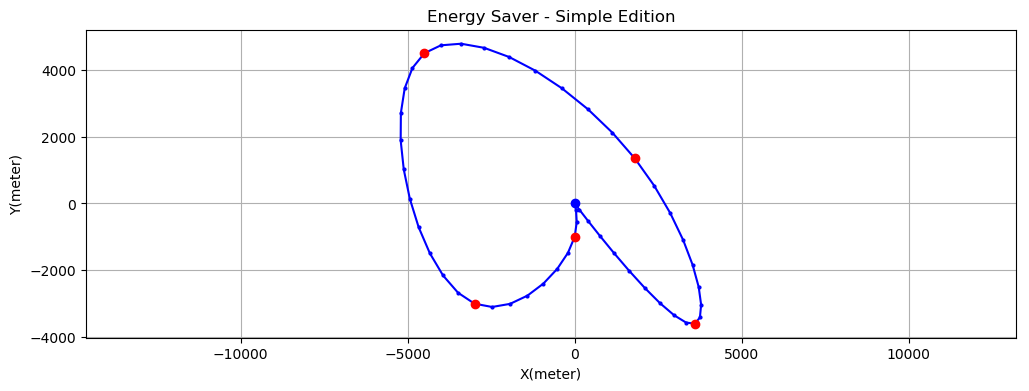

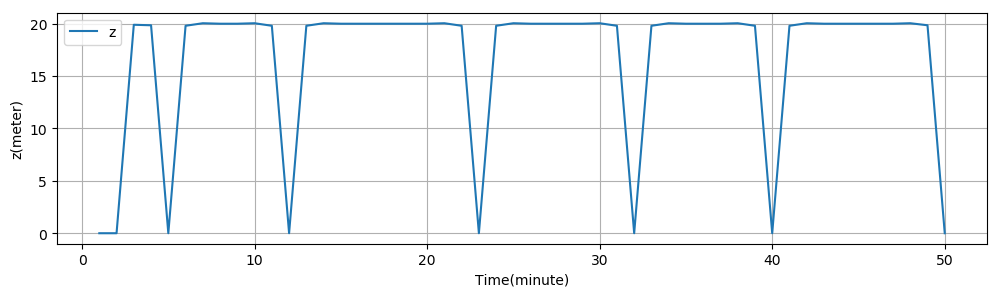

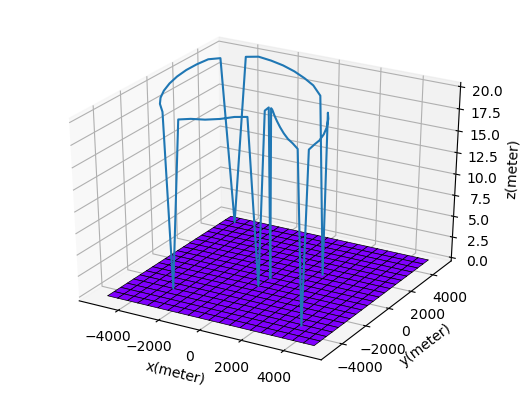

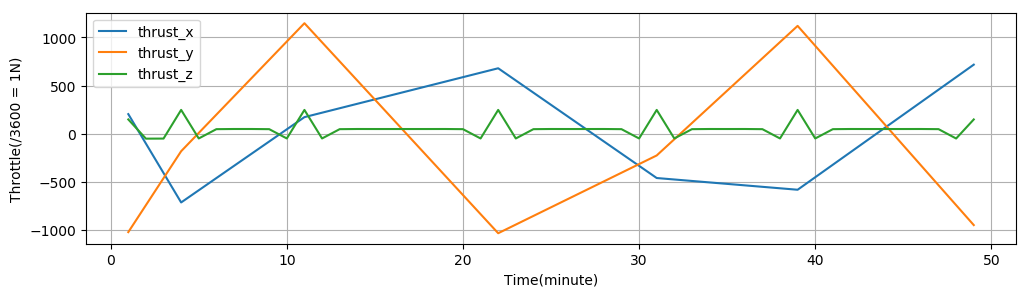

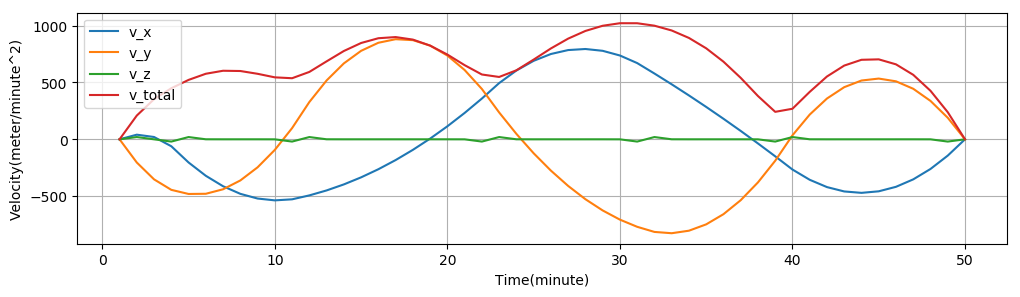

5398.218899274277
Calculation time: = 102.15386009216309 sec


In [57]:
#model 3 simple 
using JuMP, Gurobi

m3 = Model(solver = GurobiSolver(OutputFlag = 0))

@variable(m3, x[1:3, 1:I])
@variable(m3, v[1:3, 1:I])
@variable(m3, a[1:3, 1:I])
@variable(m3, tr[1:3, 1:I-1])
@variable(m3, pkg[1:M, 1:I-1], Bin)  # when package point is reached, matrix value is 0

# UAV starts at origin (0,0)
@constraint(m3, x[:,1] .== [0,0,0])
@constraint(m3, v[:,1] .== [0,0,0])

# UAV returns to origin in the end
@constraint(m3, x[:,I] .== [0,0,0])
@constraint(m3, v[:,I] .== [0,0,0])
@constraint(m3, x[3,:] .>= 0)


for t in 1:I-1
    @constraint(m3, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m3, v[:,t+1] .== v[:,t] + a[:,t])    # velocity and acceleration
    @constraint(m3, tr[:,t] + W.== (Mv) .* (a[:,t] + Ag))  
    
    for packages in 1:P  
        @constraint(m3, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m3, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m3, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m3, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m3, x[3,t] <= pkg[packages, t] * MAX_Range)
        @constraint(m3, -x[3,t] <= pkg[packages, t] * MAX_Range)
    end
end

for i in 1:P
    @constraint(m3, sum(pkg[i,:]) == I-2)
end


@objective(m3, Min, sum(tr.^2) +  10000 *sum((x[3,:].-height).^2) )

status = solve(m3)
println(status)
fuel_m3 = sum(getvalue(tr[1,:]).^2 .+ getvalue(tr[2,:]).^2. + getvalue(tr[3,:]).^2).^0.5

print3D("Energy Saver - Simple Edition")

In [61]:
#change the plain to a hill-like plain

x_cord = linspace(-6000,6000,12001)
y_cord = linspace(-6000,6000,12001)


z_cord = zeros(12001, 12001);

 for i in 1:size(x_cord)[1]
     for j in 1:size(y_cord)[1]
         z_cord[i,j] = -(x_cord[i])^2/500000 + -(y_cord[j])^2/500000
     end 
 end

In [69]:
using Gurobi
m4 = Model(solver = GurobiSolver(OutputFlag = 0))

@variable(m4, z[1:I])
@variable(m4, v[1:I])
@variable(m4, a[1:I])
@variable(m4, tr[1:I])

@constraint(m4, z[1] == 0)
@constraint(m4, z[I] == 0)

allow_range = 1

pos_x = getvalue(x[1,:])
pos_y = getvalue(x[2,:])

pos_int = zeros(Int64, 2, I)

for i in 1:I
    pos_int[1,i] = floor(pos_x[i])
    pos_int[2,i] = floor(pos_y[i])
end

println(typeof(pos_int))


for t in 1:I-1
    @constraint(m4, z[t+1] == z[t] + v[t])
    @constraint(m4, v[t+1] == v[t] + a[t])
    @constraint(m4, tr[t] + W[3] == (Mv) .* (a[t] + Ag[3]))
    @constraint(m4, z[t] - z_cord[pos_int[1,t] + 6001, pos_int[2,t] + 6001] <= allow_range)
    @constraint(m4, z[t] - z_cord[pos_int[1,t] + 6001, pos_int[2,t] + 6001] >= -allow_range)
end

@objective(m4, Min, sum(tr.^2) )

@time status = solve(m4)

Array{Int64,2}
Academic license - for non-commercial use only
  0.201928 seconds (146 allocations: 114.172 KiB)


:Optimal

In [70]:
#recording the data
z4 = getvalue(z)
time4 = getsolvetime(m2);
x4 = getvalue(x)

z4_new = x4[3,:] .+ getvalue(z);


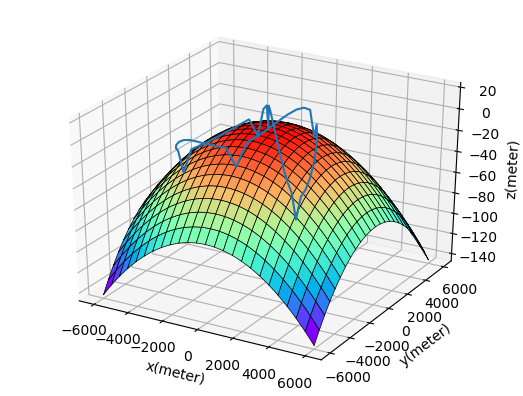

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x00000000413CD7B8>

In [71]:
using PyPlot
figure()

plot3D(x4[1,1:I], x4[2,1:I], z4_new[1:I], "-", markersize=8)
xlabel("x(meter)");ylabel("y(meter)");zlabel("z(meter)")
hold
surf(x_cord, y_cord, z_cord, rstride=500, cstride=500,cmap="rainbow", edgecolor="black", linewidths=.5)

## 4. Results and Discussion ##
### 4a. Route Results Comparison###


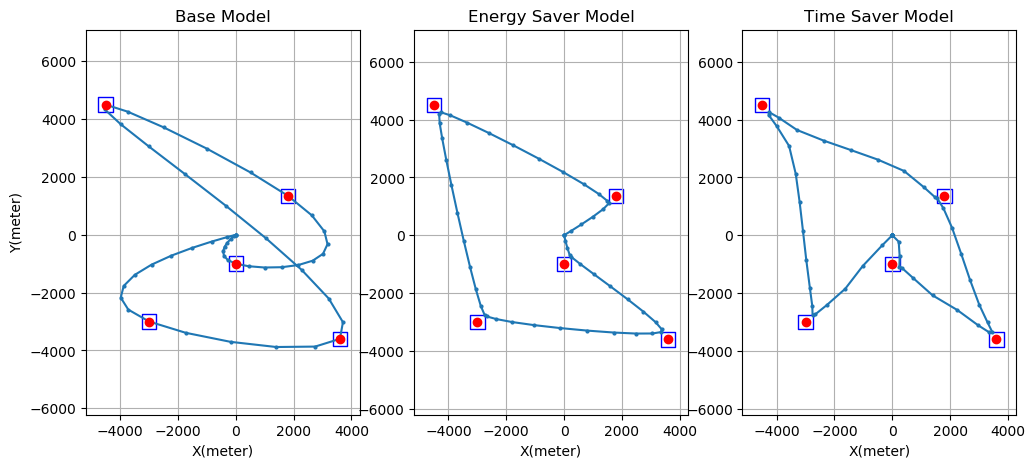

In [134]:
figure(figsize=(12,5))
subplot(131)
plot( x1[1,:], x1[2,:], ".-", markersize=4 , label = "Base Model")
plot( G[1,:], G[2,:], "r.", markersize=12 )
range_limit = 250
for i in 1:M
    broken_barh([(G[1,i] - range_limit, 2*range_limit)],(G[2,i] - range_limit, 2*range_limit), edgecolors = "blue", facecolors = "white")
end

axis("equal");
xlabel("X(meter)"); ylabel("Y(meter)"); grid();title("Base Model")


subplot(132)
plot( x2[1,:], x2[2,:], ".-", markersize=4 , label = "Energy Saver Model")
plot( G[1,:], G[2,:], "r.", markersize=12 )
range_limit = 250
for i in 1:M
    broken_barh([(G[1,i] - range_limit, 2*range_limit)],(G[2,i] - range_limit, 2*range_limit), edgecolors = "blue", facecolors = "white")
end

axis("equal");
xlabel("X(meter)"); grid();title("Energy Saver Model")


subplot(133)
plot( x3[1,:], x3[2,:], ".-", markersize=4 , label = "Time Saver Model")
plot( G[1,:], G[2,:], "r.", markersize=12 )

#acceptable dropping square
range_limit = 250
for i in 1:M
    broken_barh([(G[1,i] - range_limit, 2*range_limit)],(G[2,i] - range_limit, 2*range_limit), edgecolors = "blue", facecolors = "white")
end

axis("equal");
xlabel("X(meter)"); grid();title("Time Saver Model");

**The Base Model:** 
* It did a fairly good job in generating a feasible path to deliver all packages in time. Its path is smooth and to some extent achieved the objective of saving energy.
* However, without the throttle cap implemented in later models, the path of Base Model has some sharp corners because the throttle can be significantly huge, which cannot be possible in reality.

**The Energy Saver Model:** 
* Having a similar feature with TSP, this model would find the ***optimal sequence of dropping packages***.
* By accepting a ***dropping area*** instead of a point, the path would choose to a best point for fuel efficiency to drop the package.
* As the ***dropping speed limit*** constraint is added, the travelling speed around deliver points will slow down, thus making the path between deliver points closer to ***straight lines***. When the dropping speed limit really close to zero, this problem would become a single TSP problem. 

**The Time Saver Model:**
* Although the sequence of dropping packages is different between Time Saver Model and Energy Saver Model, their ***total path length*** seem to be ***similar***.
* The important difference between these two paths is that the travelling length between two points are more ***equalized*** in Time Saver Mode. It is probably because by equalizing the path length, the drone could increase air cruising speed in the shorter path and limit the high speed in the longer path, so that the ***average cuising speed*** would increase by almost 10%. *(This can be proven by the graph below)*
* In addition, the ***sharp corners*** appears although the maximum throttle limit is set. This effect is due to the reason that as long as the total energy usage is below the bettery storage, the drone does not need to worry about saving energy, and by flying a sharp corners, it could have a ***shorter path*** and save more time.

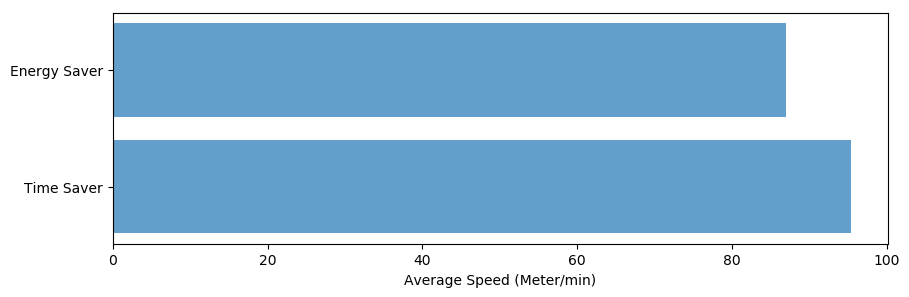

Average Speed Smaller percentage: 9.682489632973672%


In [157]:
avg_2 = sum(v2[1,:] .^ 2 + v2[2,:] .^ 2)^0.5 /I
avg_3 = sum(v3[1,:] .^ 2 + v3[2,:] .^ 2)^0.5 /I


figure(figsize=(10,3))
barh(["Time Saver", "Energy Saver"], [avg_3,avg_2] ,align="center",alpha=0.7)
xlabel("Average Speed (Meter/min)")
println("Average Speed Smaller percentage: ", (avg_3-avg_2)*100/avg_2,"%")

### 4b. Energy Consumption###


This is the comparison of Energy usage between the ***Base Model*** and ***Energy Saver Model***. 

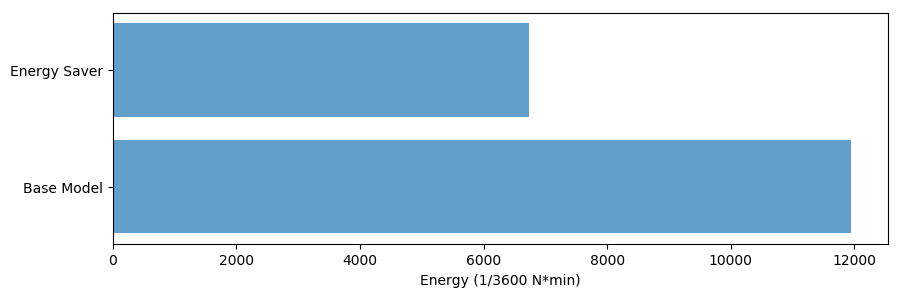

Energy saved percentage: 43.65304287425602%


In [139]:
figure(figsize=(10,3))
barh(["Base Model", "Energy Saver"], [fuel_m1,fuel_m22] ,align="center",alpha=0.7)
xlabel("Energy (1/3600 N*min)")
println("Energy saved percentage: ", (fuel_m1-fuel_m22)*100/fuel_m1,"%")

### 4c. Time length Results ###


This is the comparison of delivery time length between the ***Base Model*** and ***Time Saver Model***. 

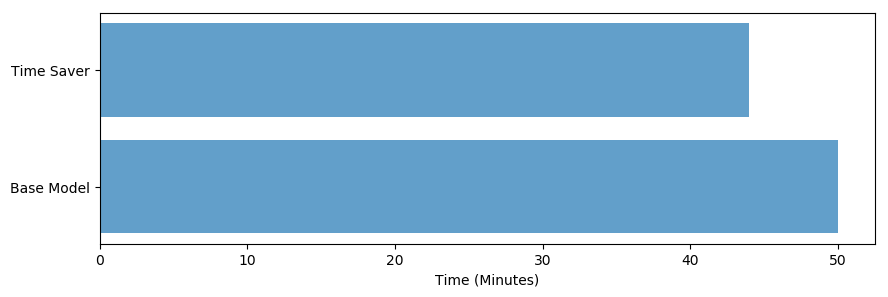

Time saved percentage: 12.0%


In [160]:
figure(figsize=(10,3))
barh(["Base Model", "Time Saver"], [50,44] ,align="center",alpha=0.7)
xlabel("Time (Minutes)")

println("Time saved percentage: ", (50-44)*100/50,"%")

### 4d. Adjusted Z Axis Position###
In the Terrain Adapted Model, the problem is solved similar to the Energy Saver Model in 3D. But as one can see in the plot, the Terrain Model re-adjusts the path to be 
above the terrain 
and passes the deliver points on the ground as well.

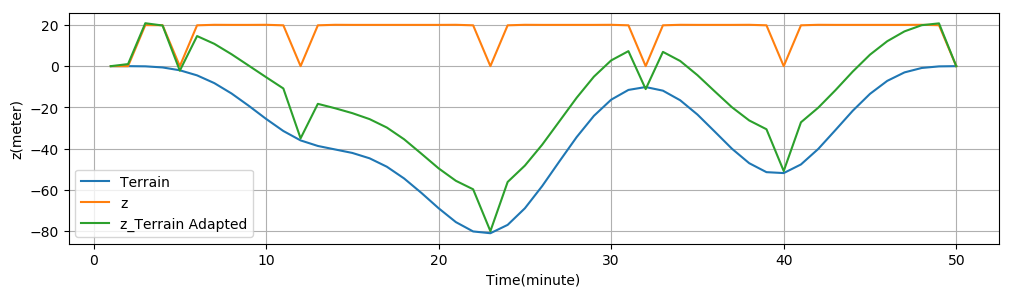

In [159]:
#Z change with time
figure(figsize = (12,3))
index_x = linspace(1,I,I)

#calculate the terrain level vs time
pos_x = x4[1,:]
pos_y = x4[2,:]
pos_int = zeros(Int64, 2, I)
for i in 1:I
    pos_int[1,i] = floor(pos_x[i])
    pos_int[2,i] = floor(pos_y[i])
end
terrain = zeros(I);
for i in 1:I
    terrain[i] = z_cord[pos_int[1,i] + 6001, pos_int[2,i] + 6001];
end

plot( index_x, terrain[1:I], "-", markersize=4 , label = "Terrain")
plot( index_x, x4[3,1:I], "-", markersize=8 , label = "z")
plot( index_x, z4_new[1:I], "-", markersize=8 , label = "z_Terrain Adapted")
xlabel("Time(minute)"); ylabel("z(meter)"); grid()
legend();

### 4e. Calculation Time###

The table below is the time we used to calculate the 4 different models.

| Model        | Calculation time(sec)          |
| ------------- |:-------------|
|Base Model|0.000995635986328125|
|Energy Saver Model|47.22983741760254|
|Time Saver Model|14692.979955673218|
|Terrain Adaption Model|0.000995635986328125|

* The Base Model and the Terrain Adaption Model took less than a second.

* Because the Energy Saver Model added 4-5 constraints at every time point, in total, about 200 constraints are added to the Model and makes the problem much harder to solve. 

* The Time Saver cost the most time to solve because the pos binary vector is added to constrain the drone return as soon as possible. This model took approximately 300 times the time used in the Energy Saver Model. 

### 4f. Effect difference between L-inf Regularization and Max Cap####

We found 2 ways to limit the maximum of the throttle.
* Setting a L-inf Regularization in the objective so that the maximum of the throttle could be minimized too.
* Setting a throttle maximum constraint to forbid the throttle to be greater than this cap.

In this section, we would run a few tests and compare the different effect of the regularization and Max cap. The test code we run can be referred in Section 6.Code Appendix. They are all simple Energy Saver with a certain constraint or objective added.

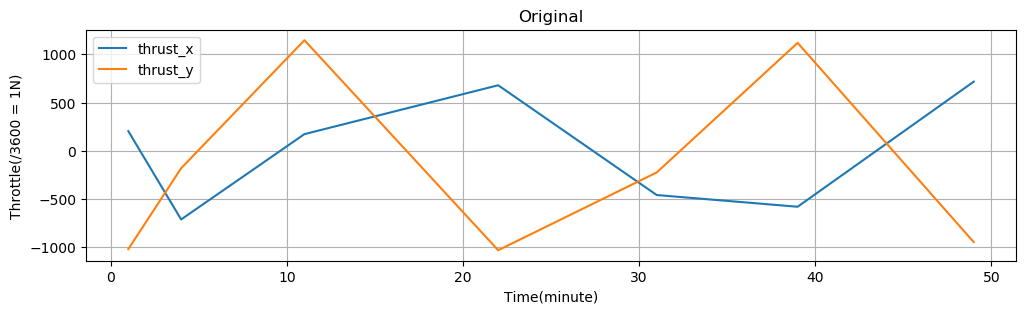

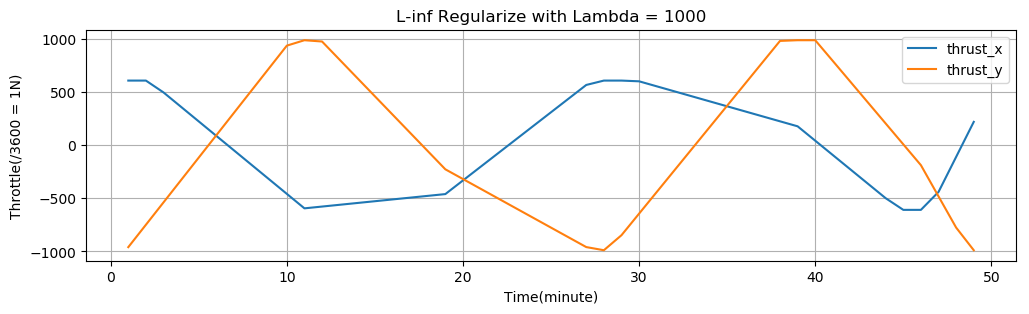

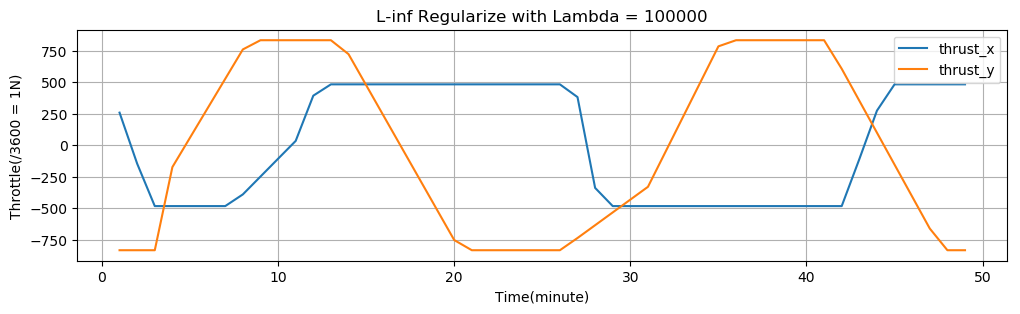

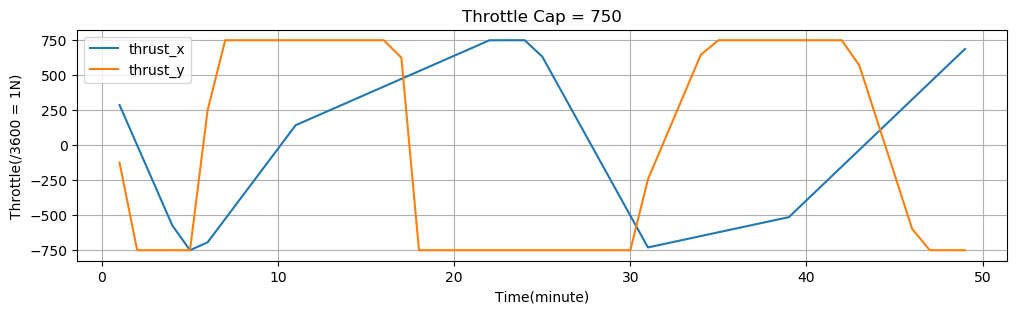

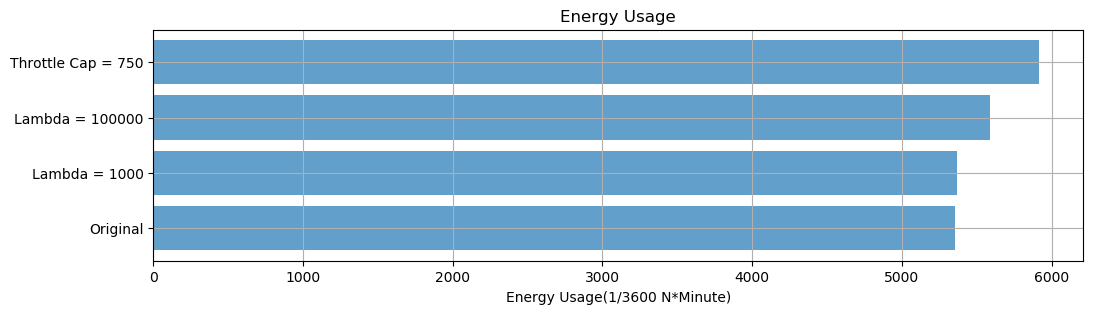

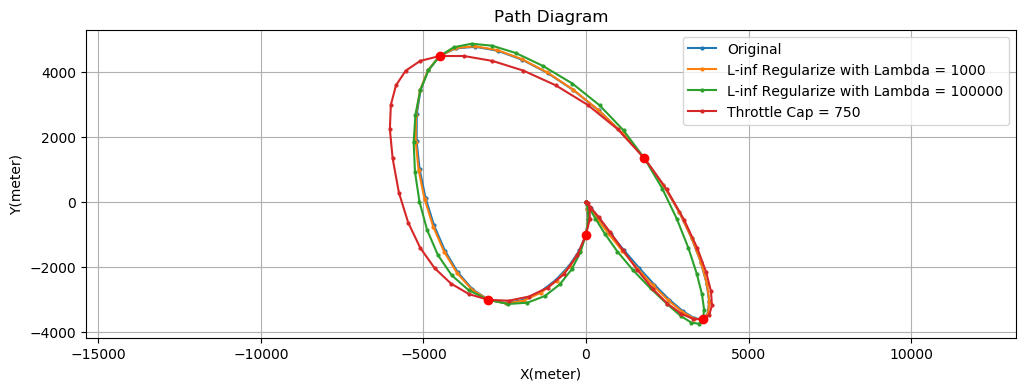

In [144]:
#original
figure(figsize = (12,3))
index_x = linspace(1,I-1,I-1)
plot( index_x, tr_o[1,1:I-1], "-", markersize=8 , label = "thrust_x")
plot( index_x, tr_o[2,1:I-1], "-", markersize=8 , label = "thrust_y")
xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid(); title("Original")
legend()

#lambda = 1000
figure(figsize = (12,3))
plot( index_x, tr_l1[1,1:I-1], "-", markersize=8 , label = "thrust_x")
plot( index_x, tr_l1[2,1:I-1], "-", markersize=8 , label = "thrust_y")
xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid(); title("L-inf Regularize with Lambda = 1000")
legend()

#lambda = 100000
figure(figsize = (12,3))
plot( index_x, tr_l2[1,1:I-1], "-", markersize=8 , label = "thrust_x")
plot( index_x, tr_l2[2,1:I-1], "-", markersize=8 , label = "thrust_y")
xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid(); title("L-inf Regularize with Lambda = 100000")
legend()

#cap = 750
figure(figsize = (12,3))
plot( index_x, tr_cap[1,1:I-1], "-", markersize=8 , label = "thrust_x")
plot( index_x, tr_cap[2,1:I-1], "-", markersize=8 , label = "thrust_y")
xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid(); title("Throttle Cap = 750")
legend()

#Energy Usage
figure(figsize = (12,3))
barh(["Original", "Lambda = 1000", "Lambda = 100000", "Throttle Cap = 750"], [fuel_o,fuel_l1,fuel_l2,fuel_cap] ,align="center",alpha=0.7);
xlabel("Energy Usage(1/3600 N*Minute)"); grid(); title("Energy Usage")

#Path
figure(figsize=(12,4))
plot( x_o[1,:], x_o[2,:], ".-", markersize=4 , label = "Original")
plot( x_l1[1,:], x_l1[2,:], ".-", markersize=4 , label = "L-inf Regularize with Lambda = 1000")
plot( x_l2[1,:], x_l2[2,:], ".-", markersize=4 , label = "L-inf Regularize with Lambda = 100000")
plot( x_cap[1,:], x_cap[2,:], ".-", markersize=4 , label = "Throttle Cap = 750")
plot( G[1,:], G[2,:], "r.", markersize=12 )
axis("equal");
xlabel("X(meter)"); ylabel("Y(meter)"); grid();legend();title("Path Diagram");

#### Discussion:####
* The L-inf Regularization Throttle limitation was more ***obvious*** when lambda is 100000 than when it is 1000.
* The L-inf Throttle when lambda is 100000 could be seen as ***2 different throttle cap*** set seperately on x and y axis.
* Limiting the throttle to a similar level, L-inf did a better job on ***saving the energy*** and its path is more ***similar to the original***.
* The ***disadvantage*** of L-inf is that, we are ***unsure*** about what is the maximum of the throttle before the result come, which makes Throttle cap more ***practical*** because the maximum of the throttle is always a fixed number for a drone.

### 4e. Effect of Wind Resistance and Dropping Speed Limit####

In this section, we are discussing how wind resistance and dropping speed limit are going to change the optimal throttle and the path.

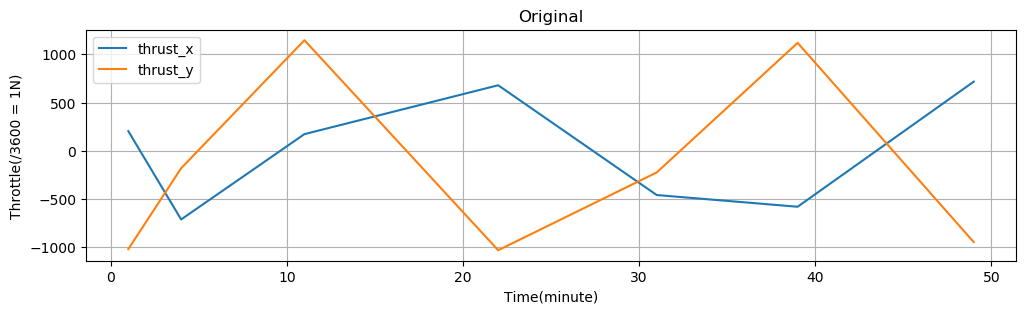

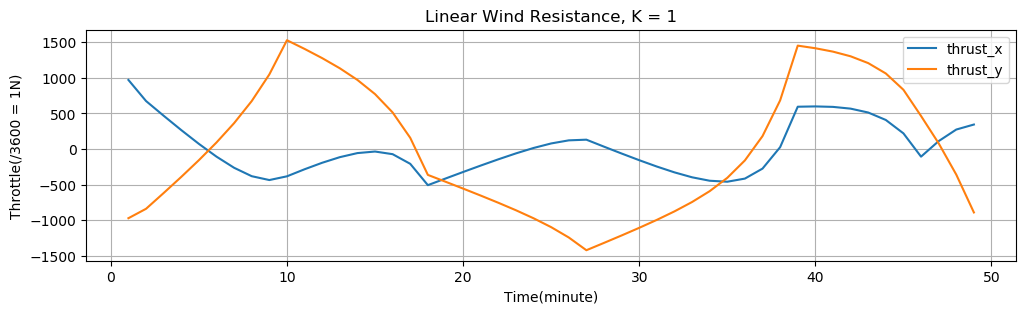

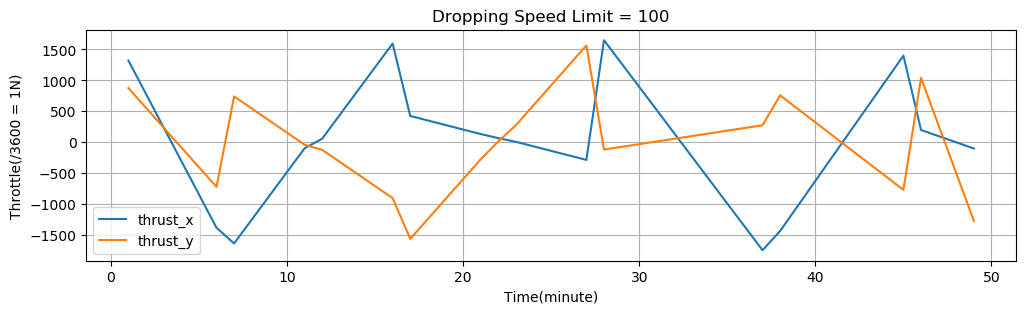

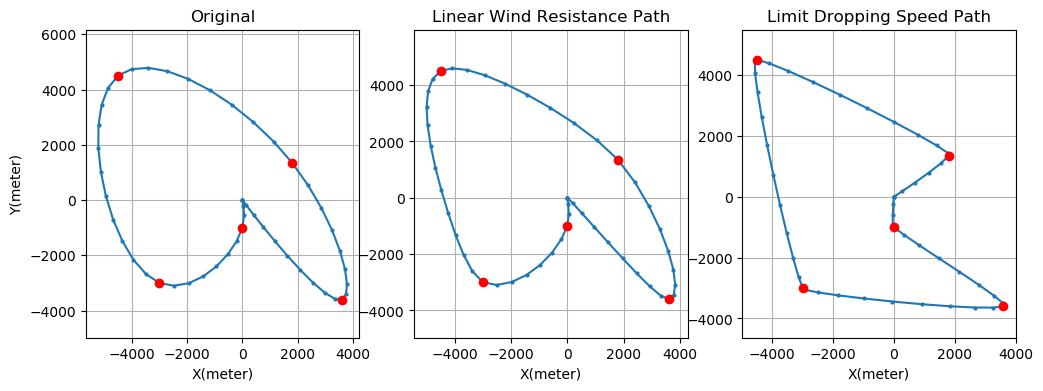

In [166]:
#original
figure(figsize = (12,3))
index_x = linspace(1,I-1,I-1)
plot( index_x, tr_o[1,1:I-1], "-", markersize=8 , label = "thrust_x")
plot( index_x, tr_o[2,1:I-1], "-", markersize=8 , label = "thrust_y")
xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid(); title("Original")
legend()

#linear wind resistance
figure(figsize = (12,3))
plot( index_x, tr_res[1,1:I-1], "-", markersize=8 , label = "thrust_x")
plot( index_x, tr_res[2,1:I-1], "-", markersize=8 , label = "thrust_y")
xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid(); title("Linear Wind Resistance, K = 1")
legend()

#corner speed
figure(figsize = (12,3))
plot( index_x, tr_cor[1,1:I-1], "-", markersize=8 , label = "thrust_x")
plot( index_x, tr_cor[2,1:I-1], "-", markersize=8 , label = "thrust_y")
xlabel("Time(minute)"); ylabel("Throttle(/3600 = 1N)"); grid(); title("Dropping Speed Limit = 100")
legend()


#Path
figure(figsize=(12,4))
subplot(131)
plot( x_o[1,:], x_o[2,:], ".-", markersize=4 , label = "Original")
plot( G[1,:], G[2,:], "r.", markersize=12 )
axis("equal");
xlabel("X(meter)"); ylabel("Y(meter)"); grid();title("Original")


subplot(132)
plot( x_res[1,:], x_res[2,:], ".-", markersize=4 , label = "Linear Wind Resistance, K = 1")
plot( G[1,:], G[2,:], "r.", markersize=12 )
axis("equal");
xlabel("X(meter)");  grid();;title("Linear Wind Resistance Path")

subplot(133)
plot( x_cor[1,:], x_cor[2,:], ".-", markersize=4 , label = "Dropping Speed Limit = 100")
plot( G[1,:], G[2,:], "r.", markersize=12 )
axis("equal");
xlabel("X(meter)");  grid();title("Limit Dropping Speed Path");

Wind Resistance Discussion:
* Comparing the throttle of Original and one with wind resistance, we found out that the wind resistance make the throttle changing more ***curved*** instead of the straight line.
* In the path map, wind resistance make the path a bit more straight because the ***slowing effect*** would decrease the speed cumulated over time.

Limit Dropping Speed Discussion:
* Comparing the throttle of Original and one with limit dropping speed, the throttle was changing more ***frequently and fiercely*** after the dropping speed cap was implemented.
* In the path map, limit dropping speed make the solver to choose the ***shorter path***.

## 5. Conclusion##
### 5.a Summary###
With the use of Julia, JuMP, and Gurobi, this project successfully solve four models to optimize different objectives.   
* The first model find the path which consumes the least energy when the entire time line on dropping several packages is fixed. 
* Improved from the first model, the seconde mode "Energy Saver" could not only optimize the route, but find the best sequence of dropping and dropping time itself. It took 43.65% of energy less than the first model.
* The third model optimize the route for the fastest delivery, with the limitation of Energy Total. In fact, it took 12% of time less to deliver all packages and go back to origin than the first model.
* The fourth model optimize the height of the path when the model is in 3 dimensions. It modifies the height to adapt with terrain's rise and fall.  

In addition to finding the optimal path, we are also trying to understand why the path varies with different objectives and how the realistic factors such as wind resistance affect the optimal path. From this project, we gained a much deeper understanding on Feedback Control System and Traveler Salesman Problem. We are also more familiar with each kind of solvers capablility on Linear, Quadratic, and Integer Programming.


### 5.b Future Directions###
In the future, there are many aspects that this project could be improven on.
* Running it with CUDA to decrease the calculation time.
* Adding more realistic features to the model, such as mass change while drone is dropping the package, wind resistance quadratic to the speed, and a more detailed height map with buildings.
* Implementing a trade-off between the Energy Saving and Time Saving.
* Building up a system that could allow multiple drones in the map and avoid collisions.

## 6. Code Appendix ##

In [76]:
M = 5 #number of dropping area
P = 5 #number of packages
I = 50 #maximum time of flying
G = [0 1800 -4500 3600 -3000;-1000 1350 4500 -3600 -3000] #dropping target coordinates
W = [0,0] #wind speed
Mv = 5 #mass of the drone
Ag = [0,0] #gravity acceleration
T = [10, 20, 25, 35, 40, 45] #time index when the drone drop the package
MAX_Range = 10^6 #max range the drone could fly
range_limit = 0; #length of the side for the square dropping area

In [77]:
#Original Model with no realistic factor(Simple Energy Saver Model)
using JuMP, Gurobi, Mosek

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

coeff_v = 0.3
vlimit = 100

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I], Bin)

# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])
for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration    
    @constraint(m2, tr[:,t] + W .== (Mv) .* (a[:,t] + Ag))  
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

lambda = 1000

@objective(m2, Min, sum(tr.^2))

@time status = solve(m2)
println(status)
fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2))^0.5

#recording the data
x_o = getvalue(x)
tr_o = getvalue(tr)
v_o = getvalue(v)
a_o = getvalue(a)
fuel_o = fuel_m2
time_o = getsolvetime(m2);

Academic license - for non-commercial use only
198.027187 seconds (3.56 M allocations: 181.052 MiB)
Optimal


In [79]:
#Simple Energy Saver Model L-inf regularization on throttle, lambda = 1000
using JuMP, Gurobi, Mosek

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

coeff_v = 0.3
vlimit = 100

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I], Bin)
@variable(m2, max_tr[1:2] >= 0)


# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration

    @constraint(m2, tr[:,t] + W .== (Mv) .* (a[:,t] + Ag))  
    @constraint(m2, max_tr[:] .>= tr[:,t])
    @constraint(m2, max_tr[:] .>= -tr[:,t])
    
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

lambda = 1000

#L-inf regularizing
@objective(m2, Min, sum(tr.^2) + lambda*sum(max_tr))

@time status = solve(m2)
println(status)
fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2))^0.5

#recording the data
x_l1 = getvalue(x)
tr_l1 = getvalue(tr)
v_l1 = getvalue(v)
a_l1 = getvalue(a)
fuel_l1 = fuel_m2
time_l1 = getsolvetime(m2);

Academic license - for non-commercial use only
541.282854 seconds (154 allocations: 565.469 KiB)
Optimal


In [80]:
#Simple Energy Saver Model L-inf regularization on throttle, lambda = 100000
using JuMP, Gurobi, Mosek

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

coeff_v = 0.3
vlimit = 100

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I], Bin)
@variable(m2, max_tr[1:2] >= 0)


# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration
    
    @constraint(m2, tr[:,t] + W .== (Mv) .* (a[:,t] + Ag))  
    @constraint(m2, max_tr[:] .>= tr[:,t])
    @constraint(m2, max_tr[:] .>= -tr[:,t])
    
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

lambda = 100000

#smoothing and equalizing
@objective(m2, Min, sum(tr.^2) + lambda*sum(max_tr))

@time status = solve(m2)
println(status)
fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2))^0.5

x_l2 = getvalue(x)
tr_l2 = getvalue(tr)
v_l2 = getvalue(v)
a_l2 = getvalue(a)
fuel_l2 = fuel_m2
time_l2 = getsolvetime(m2);

Academic license - for non-commercial use only
154.008923 seconds (154 allocations: 565.469 KiB)
Optimal


In [81]:
#Simple Energy Saver with Speed Maximum Cap setted
using JuMP, Gurobi, Mosek

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

coeff_v = 0.3
vlimit = 100

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I], Bin)


# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration
    
    @constraint(m2, tr[:,t] + W .== (Mv) .* (a[:,t] + Ag))  
    @constraint(m2, tr[:,t] .<= 750)
    @constraint(m2, -tr[:,t] .<= 750)
    
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

lambda = 1000

@objective(m2, Min, sum(tr.^2))

@time status = solve(m2)
println(status)
fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2))^0.5

x_cap = getvalue(x)
tr_cap = getvalue(tr)
v_cap = getvalue(v)
a_cap = getvalue(a)
fuel_cap = fuel_m2
time_cap = getsolvetime(m2);

Academic license - for non-commercial use only
 29.863875 seconds (154 allocations: 542.844 KiB)
Optimal


In [112]:
#Simple Energy Saver Model with linear resistance
using JuMP, Gurobi, Mosek

m2 = Model(solver = GurobiSolver(OutputFlag = 0))

coeff_v = 1
vlimit = 100

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I], Bin)
@variable(m2, resistance[1:2,1:I])


# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])
@constraint(m2, resistance[:,1] .== [0,0])

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration
    
    @constraint(m2, resistance[t] == coeff_v * sum(v[:,t]))
    @constraint(m2, tr[:,t] + W - resistance[t] .== (Mv) .* (a[:,t] + Ag))
    
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

lambda = 1000

@objective(m2, Min, sum(tr.^2))

@time status = solve(m2)
println(status)
fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2))^0.5


x_res = getvalue(x)
tr_res = getvalue(tr)
v_res = getvalue(v)
a_res = getvalue(a)
fuel_res = fuel_m2
time_res = getsolvetime(m2);

Academic license - for non-commercial use only
508.309436 seconds (154 allocations: 549.813 KiB)
Optimal


In [113]:
#Simple Energy Saver Model with package dropping speed limit 100
using JuMP, Gurobi, Mosek

m2 = Model(solver = GurobiSolver(OutputFlag = 0))
coeff_v = 0.3
vlimit = 100

@variable(m2, x[1:2, 1:I])
@variable(m2, v[1:2, 1:I])
@variable(m2, a[1:2, 1:I])
@variable(m2, tr[1:2, 1:I-1])
@variable(m2, pkg[1:M, 1:I], Bin)
@variable(m2, resistance[1:2,1:I])

# UAV starts at origin (0,0) 
@constraint(m2, x[:,1] .== [0,0])
@constraint(m2, v[:,1] .== [0,0])

# UAV returns to origin in the end
@constraint(m2, x[:,I] .== [0,0])
@constraint(m2, v[:,I] .== [0,0])
@constraint(m2, resistance[:,1] .== [0,0])

for t in 1:I-1
    @constraint(m2, x[:,t+1] .== x[:,t] + v[:,t])    # position and velocity 
    @constraint(m2, v[:,t+1] .== v[:,t] + a[:,t])  # velocity and acceleration
    
    @constraint(m2, tr[:,t] + W .== (Mv) .* (a[:,t] + Ag))  
    
    for packages in 1:P  
        @constraint(m2, x[1,t] - G[1,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[1,t] - G[1,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] <= pkg[packages, t] * MAX_Range)
        @constraint(m2, x[2,t] - G[2,packages] >= -pkg[packages, t] * MAX_Range)
        @constraint(m2, v[1,t]^2+v[2,t]^2  <= pkg[packages, t] * MAX_Range + vlimit^2)
    end
        
end

for i in 1:P
    @constraint(m2, sum(pkg[i,:]) == I-2)
end

lambda = 1000

@objective(m2, Min, sum(tr.^2))

@time status = solve(m2)
println(status)
fuel_m2 = sum(getvalue((tr[1,:]).^2) .+ getvalue((tr[2,:]).^2))^0.5

x_cor = getvalue(x)
tr_cor = getvalue(tr)
v_cor = getvalue(v)
a_cor = getvalue(a)
fuel_cor = fuel_m2
time_cor = getsolvetime(m2);

Academic license - for non-commercial use only
449.194061 seconds (3.09 k allocations: 683.859 KiB)
Optimal
